In [50]:
!pip install numpy
!pip install pandas
!pip install tensorflow
!pip install keras
!pip install -U scikit-learn
!pip install matplotlib
!pip install seaborn

In [51]:
#importing the libraries needed
import numpy as np
import pandas as pd
import tensorflow as tf
from math import floor, ceil
import sklearn as sk
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Bidirectional, LSTM,Masking,Embedding
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, accuracy_score, make_scorer
from sklearn.model_selection import cross_validate,train_test_split,GridSearchCV
from sklearn.preprocessing import normalize
from tensorflow.keras.models import load_model 
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from scikeras.wrappers import KerasClassifier
import matplotlib.pyplot as pyplot
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay #, plot_confusion_matrix
import time
import json
import ast
import os


# Linear Algebra Flipped

In [52]:
data_path = '../mooc-pipeline/data/result/easy-fail/'

# set week type, feature types, and courses here
week_type = 'eq_week'
feature_types = [ 'boroujeni_et_al', 
                 'chen_cui',  'lalle_conati', 
                 'marras_et_al']
marras_et_al_id = feature_types.index('marras_et_al')
#akpinar_et_al_id = feature_types.index('akpinar_et_al')
courses = ['villesafricaines_001']

# boolean: if True, remove features directly related to student success in weekly quizzes:
# student shape, competency alignment, competency strength
remove_obvious = False

# set number of epochs to train models for each course:
params = {}
for course in courses:
    params[course] = {'num_epochs':12}

In [53]:
# Loading the features
feature_list = {}
num_weeks= 6

for course in courses:
    feature_type_list = []
    for feature_type in feature_types:
    
        filepath = data_path + week_type + '-' + feature_type + '-' + course
        feature_current = np.load(filepath+'/feature_values.npz')['feature_values']
        print(feature_type, feature_current.shape)
        print(np.count_nonzero(np.isnan(feature_current).any(axis=0)))
        feature_norm = feature_current.reshape(-1,feature_current.shape[2] )
#         print(feature_norm.shape)
        feature_type_list.append(pd.DataFrame(feature_norm))
    feature_list[course] = feature_type_list

print('course: ', courses)
print('week_type: ', week_type)
print('feature_type: ', feature_types)

boroujeni_et_al (4941, 13, 3)
39
chen_cui (4941, 13, 13)
26
lalle_conati (4941, 13, 22)
45
marras_et_al (4941, 13, 7)
47
course:  ['villesafricaines_001']
week_type:  eq_week
feature_type:  ['boroujeni_et_al', 'chen_cui', 'lalle_conati', 'marras_et_al']


In [54]:
def clean_name(feature):
    id = feature.find('<')
    if id==-1:
        return feature
    fct = feature[id+9:id+14].strip()
    return feature[0:id]+fct

def clean_akp_name(feature):
    feature = feature.lower()
    if feature.find("(")!=-1:
        feature = feature[1:-1]
        feature = feature.replace(', ', '-')
    return feature
    

In [55]:
# Loading feature names
feature_names= dict()

for feature_type in feature_types:
    
    filepath = data_path + week_type + '-' + feature_type + '-' + course + '/settings.txt'
    file = open(filepath, "r")
    contents = file.read()
    dictionary = ast.literal_eval(contents)
    file.close()
    
    feature_type_name = dictionary['feature_names']
    
    # reformat feature names
    # ex: time_sessions_<function sum at 0x7f3bd02cc9d0> -> time_sessions_sum
    feature_type_name = [clean_name(x) for x in feature_type_name]
    
    # for akpinar_et_al, just use the features listed below
    if feature_type == 'akpinar_et_al': 
        feature_type_name = [clean_akp_name(x) for x in feature_type_name]
        akp_mask = np.where(np.isin(feature_type_name, 
                 ["total_clicks", "number_sessions", "time_in__video_sum", "time_in__problem_sum",
                  'problem.check-problem.check-problem.check', 
                  'problem.check-problem.check-video.load', 
                  'video.play-video.play-video.play',
                  'video.play-video.pause-video.load',
                  'video.play-problem.check-problem.check',
                  'video.play-video.stop-video.play',
                  'video.pause-video.speedchange-video.play',
                  'video.stop-video.play-video.seek',
                  'video.stop-problem.check-video.load']))
        print(akp_mask)
        feature_type_name = list(np.array(feature_type_name)[akp_mask[0]])
        feature_list[course][akpinar_et_al_id] = feature_list[course][akpinar_et_al_id][akp_mask[0]]
        
        
    feature_names[feature_type] = feature_type_name
    print(feature_type, len(feature_type_name))

if remove_obvious: 
    # drop 'student shape', 'competency strength', 'competency alignment' in marras at al
    
    mr_mask = np.where(np.isin(feature_names['marras_et_al'], 
                 ['student_shape', 'competency_strength', 'competency_alignment']))
    
    new_marras = np.delete(np.array(feature_names['marras_et_al']), mr_mask[0])
    feature_names['marras_et_al'] = new_marras
    
    for course in courses: 
        new_features = feature_list[course][marras_et_al_id].drop(mr_mask[0], axis=1)
        feature_list[course][marras_et_al_id] = new_features


boroujeni_et_al 3
chen_cui 13
lalle_conati 22
marras_et_al 7


In [56]:
# Bidirection LSTM definition

def bidirectional_lstm(x_train, y_train, x_test, y_test, x_val, y_val, 
                       week_type, feature_types, course,n_weeks,n_features, 
                       hidden_feature_num=[8, 8], batch_size=32, num_epochs=100):
    n_dims = x_train.shape[0]
    look_back = 3
    # LSTM
    # define model
    lstm = Sequential()
    ###########Reshape layer################
    lstm.add(tf.keras.layers.Reshape((n_weeks, n_features), input_shape=(n_weeks*n_features,)))
    ##########deleting the 1.001 max row added###########
    lstm.add(Masking(mask_value = 1))
    lstm.add(Bidirectional(LSTM(hidden_feature_num[0], return_sequences=True)))
    lstm.add(Bidirectional(LSTM(hidden_feature_num[1])))
    # Add a sigmoid Dense layer with 1 units.
    lstm.add(Dense(1, activation='sigmoid'))
    # compile the model
    lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    # fit the model
    history = lstm.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=num_epochs, batch_size=batch_size, verbose=1)
    # evaluate the model
    y_pred = lstm.predict(x_test)
    y_pred = [1 if y[0] >= 0.5 else 0 for y in y_pred]
    # evaluate the model
    model_params = {'model': 'LSTM-bi', 'epochs': num_epochs, 
                    'hidden_feature_num': hidden_feature_num,
                    'batch_size': batch_size, 'loss': 'binary_cross_entropy'}
    scores = evaluate(None, x_test, y_test, week_type, feature_types, course, 
                      hidden_feature_num,
                      y_pred=y_pred, 
                      model_name="TF-LSTM-bi", model_params=model_params)
    
    file = 'models/' + course + "_biLSTM_results_" + str(num_weeks) + "_weeks.json"
    with open(file, 'w') as f: 
        json.dump(scores, f)
        
    # Original (without.keras)
    lstm.save('models/lstm_bi_'+ course + "_" + current_timestamp + "_" + str(num_weeks) + "_weeks")
    
    # Saves Keras file but then error in LIME notebook
    #lstm.save('models/lstm_bi_'+ course + "_" + current_timestamp + "_" + str(num_weeks) + "_weeks_test.h5")
    
    # Error with .tf or .h5 format
    # tf.keras.models.save_model(lstm, 'models/lstm_bi_'+ course + "_" + current_timestamp + "_" + str(num_weeks) + "_weeks_test.tf")
    
    # Works but then it's loaded as "generic model" so it's type "_UserObject" in LIME notebook
    #tf.saved_model.save(lstm,'models/lstm_bi_'+ course + "_" + current_timestamp + "_" + str(num_weeks) + "_weeks")    
    
    # New function
    #lstm.export('models/lstm_bi_'+ course + "_" + current_timestamp + "_" + str(num_weeks) + "_weeks_test.keras")

    return history, scores, lstm

In [57]:
def plot_history(history, filename):
    fig, axs = pyplot.subplots(1,1, figsize=(6,3))
    sns.lineplot(x=range(len(history.history['loss'])), y=history.history['loss'], label='train', ax=axs)
    sns.lineplot(x=range(len(history.history['loss'])), y=history.history['val_loss'], label='test',ax=axs)
    axs.set_title('Loss ' + filename)
    axs.set_xlabel('epoch')
    axs.set_ylabel('loss')
#     pyplot.savefig(filename+'_loss.png')

    fig, axs = pyplot.subplots(1,1, figsize=(6,3))
    sns.lineplot(x=range(len(history.history['loss'])), y=history.history['accuracy'], label='train', ax=axs)
    sns.lineplot(x=range(len(history.history['loss'])), y=history.history['val_accuracy'], label='test',ax=axs)
    axs.set_title('Accuracy '+ filename)
    axs.set_xlabel('epoch')
    axs.set_ylabel('accuracy')
    #pyplot.savefig(filename+'_acc.png')

In [58]:
def evaluate(model, x_test, y_test, week_type, feature_type, course, 
             hidden_feature_num,
             model_name=None, model_params=None, y_pred=None):
    scores={}
    scores['test_acc'] = accuracy_score(y_test, y_pred)
    scores['test_bac'] = balanced_accuracy_score(y_test, y_pred)
    scores['test_prec'] = precision_score(y_test, y_pred)
    scores['test_rec'] = recall_score(y_test, y_pred)
    scores['test_f1'] = f1_score(y_test, y_pred)
    scores['test_auc'] = roc_auc_score(y_test, y_pred)
    scores['feature_type'] = feature_type
    scores['week_type'] = week_type
    scores['course'] = course
    scores['hidden_feature_num_1'] = hidden_feature_num[0]
    scores['hidden_feature_num_2'] = hidden_feature_num[1]
    scores['data_balance'] = sum(y)/len(y)
    
    return scores

In [59]:
# fillNaN function replaces NaNs in each week with the minimum of the feature over all weeks

def fillNaN(feature):
    shape = feature.shape
    feature_min = np.nanmin(feature.reshape(-1,shape[2]),axis=0)
    feature = feature.reshape(-1,shape[2])
    inds = np.where(np.isnan(feature))
    feature[inds] = np.take(feature_min.reshape(-1), inds[1])
    feature = feature.reshape(shape)
    return feature

In [60]:
# load data and normalize

def load_labels(course):
    feature_type = "boroujeni_et_al"
    filepath = data_path + week_type + '-' + feature_type + '-' + course + '/feature_labels.csv'
    labels = pd.read_csv(filepath)['label-pass-fail']
    labels[labels.shape[0]] = 1
    return labels.values

def load_features(course):
    feature_list = []
    selected_features = []
    total_features = set()
    num_weeks = 0
    num_features = 0
    for i,feature_type in enumerate(feature_types):
        try:
            filepath = data_path + week_type + '-' + feature_type + '-' + course 
            feature_current = np.load(filepath+'/feature_values.npz')['feature_values']
            print(feature_type)
            shape = feature_current.shape
    #         print(shape)

            if remove_obvious and feature_type=='marras_et_al':
                feature_current = np.delete(feature_current, mr_mask, axis=2)

            if feature_type=='akpinar_et_al':
                print(akp_mask[0])
                akp_mask_dl = np.delete(list(range(shape[2])), akp_mask[0])
                feature_current = np.delete(feature_current, akp_mask_dl, axis=2)

            shape = feature_current.shape
    #         print(shape)
            if i==0:
                num_weeks = shape[1]
                num_weeks = 6
                

            selected = np.arange(shape[2])
            # drop existed features
            exist_mask = []
            for i, name in enumerate(feature_names[feature_type]):
                if name in total_features:
                    exist_mask.append(i)
                else:
                    total_features.add(name)
    #         print(exist_mask, feature_current.shape)
            feature_current = np.delete(feature_current, exist_mask, axis=2)
            selected = np.delete(selected, exist_mask)

#             print(feature_current.shape)
            nonNaN = (shape[0]*shape[1] - np.isnan(feature_current.reshape(-1,feature_current.shape[2])).sum(axis=0) > 0)
            feature_current = feature_current[:,:,nonNaN]
            selected = selected[nonNaN]
            feature_current = fillNaN(feature_current)
            nonZero = (abs(feature_current.reshape(-1,feature_current.shape[2])).sum(axis=0)>0)
            selected = selected[nonZero]
            
            # added this line here for selecting WEEKS
            feature_current = feature_current[:,:num_weeks,nonZero]


    #         print(feature_type, feature_current.shape)
            selected_features.append(np.array(feature_names[feature_type])[[selected]])

            ##### Normalization with min-max. Added the artifical 1.001 max row for solving the same min max problem
            ##### for features with max=0 I added 1 instead of 1.001 of maximum

            features_min = feature_current.min(axis=0).reshape(-1)
            features_max = feature_current.max(axis=0)
            features_max = np.where(features_max==0,np.ones(features_max.shape),features_max)
            max_instance = 1.001*features_max
            feature_current = np.vstack([feature_current,max_instance.reshape((1,)+max_instance.shape)])
            features_max = features_max.reshape(-1)
            feature_norm = (feature_current.reshape(shape[0]+1,-1)-features_min)/(1.001*features_max-features_min)
            feature_current = feature_norm.reshape(-1,feature_current.shape[1],feature_current.shape[2] )
            print(feature_current.shape)
            
            num_features += feature_current.shape[2]
            
            feature_list.append(feature_current)
        except:
            print('{} is not valiad'.format(feature_type))
        
    features = np.concatenate(feature_list, axis=2)
#     print(features.shape)
    features = features.reshape(features.shape[0],-1)
#     features = pd.DataFrame(features, columns=total_features)
    
    SHAPE = features.shape
    # print(np.isnan(features[0,0,-1]))
    print('features shape:', features.shape)
    print('course: ', course)
    print('week_type: ', week_type)
    print('feature_type: ', feature_types)
    print(selected_features)
    return features, selected_features, num_weeks, num_features


In [61]:
labels = {}
features = {}
selected_features = {}


for course in courses:
    print(course)
    labels[course] = load_labels(course)
    feats, sel_feats, num_weeks, num_features = load_features(course)
    features[course] = feats
    selected_features[course] = sel_feats
    params[course]['num_weeks'] = num_weeks
    params[course]['num_features'] = num_features

villesafricaines_001
boroujeni_et_al
(4942, 6, 3)
chen_cui
(4942, 6, 13)
lalle_conati
(4942, 6, 13)
marras_et_al
(4942, 6, 3)
features shape: (4942, 192)
course:  villesafricaines_001
week_type:  eq_week
feature_type:  ['boroujeni_et_al', 'chen_cui', 'lalle_conati', 'marras_et_al']
[array([['regularity_peak_dayhour', 'regularity_periodicity_m1',
        'delay_lecture']], dtype='<U25'), array([['total_clicks', 'number_sessions', 'time_sessions_sum',
        'time_sessions_mean', 'time_between_sessions_std',
        'time_sessions_std', 'total_clicks_weekday',
        'total_clicks_weekend', 'ratio_clicks_weekend_day',
        'total_clicks_video', 'total_clicks_problem',
        'time_in__problem_sum', 'time_in__video_sum']], dtype='<U25'), array([['total_clicks_Video.Load', 'weekly_prop_watched_mean',
        'weekly_prop_replayed_mean', 'weekly_prop_interrupted_mean',
        'total_clicks_Video', 'frequency_action_Video',
        'frequency_action_Video.Load', 'frequency_action_Vide

In [62]:
course = 'villesafricaines_001'
final_features = dict()

for i, feature_type in enumerate(feature_types):
    final_features[feature_type] = list(selected_features[course][i])
    
print(final_features)

{'boroujeni_et_al': [array(['regularity_peak_dayhour', 'regularity_periodicity_m1',
       'delay_lecture'], dtype='<U25')], 'chen_cui': [array(['total_clicks', 'number_sessions', 'time_sessions_sum',
       'time_sessions_mean', 'time_between_sessions_std',
       'time_sessions_std', 'total_clicks_weekday',
       'total_clicks_weekend', 'ratio_clicks_weekend_day',
       'total_clicks_video', 'total_clicks_problem',
       'time_in__problem_sum', 'time_in__video_sum'], dtype='<U25')], 'lalle_conati': [array(['total_clicks_Video.Load', 'weekly_prop_watched_mean',
       'weekly_prop_replayed_mean', 'weekly_prop_interrupted_mean',
       'total_clicks_Video', 'frequency_action_Video',
       'frequency_action_Video.Load', 'frequency_action_Video.Play',
       'frequency_action_Video.Pause', 'pause_duration_mean',
       'pause_duration_std', 'time_speeding_up_mean',
       'time_speeding_up_std'], dtype='<U35')], 'marras_et_al': [array(['content_alignment', 'content_anticipation', 'st

In [63]:
final_features

{'boroujeni_et_al': [array(['regularity_peak_dayhour', 'regularity_periodicity_m1',
         'delay_lecture'], dtype='<U25')],
 'chen_cui': [array(['total_clicks', 'number_sessions', 'time_sessions_sum',
         'time_sessions_mean', 'time_between_sessions_std',
         'time_sessions_std', 'total_clicks_weekday',
         'total_clicks_weekend', 'ratio_clicks_weekend_day',
         'total_clicks_video', 'total_clicks_problem',
         'time_in__problem_sum', 'time_in__video_sum'], dtype='<U25')],
 'lalle_conati': [array(['total_clicks_Video.Load', 'weekly_prop_watched_mean',
         'weekly_prop_replayed_mean', 'weekly_prop_interrupted_mean',
         'total_clicks_Video', 'frequency_action_Video',
         'frequency_action_Video.Load', 'frequency_action_Video.Play',
         'frequency_action_Video.Pause', 'pause_duration_mean',
         'pause_duration_std', 'time_speeding_up_mean',
         'time_speeding_up_std'], dtype='<U35')],
 'marras_et_al': [array(['content_alignment', 

(3953, 192) (494, 192) (495, 192)
(3953,) (494,) (495,)
bidirectional_lstm
Epoch 1/12
124/124 [==============================] - 9s 17ms/step - loss: 0.3143 - accuracy: 0.8953 - val_loss: 0.1797 - val_accuracy: 0.9152
Epoch 2/12
124/124 [==============================] - 1s 5ms/step - loss: 0.1792 - accuracy: 0.9221 - val_loss: 0.1558 - val_accuracy: 0.9192
Epoch 3/12
124/124 [==============================] - 1s 5ms/step - loss: 0.1630 - accuracy: 0.9228 - val_loss: 0.1720 - val_accuracy: 0.9091
Epoch 4/12
124/124 [==============================] - 1s 4ms/step - loss: 0.1605 - accuracy: 0.9221 - val_loss: 0.1371 - val_accuracy: 0.9293
Epoch 5/12
124/124 [==============================] - 1s 4ms/step - loss: 0.1528 - accuracy: 0.9279 - val_loss: 0.1384 - val_accuracy: 0.9253
Epoch 6/12
124/124 [==============================] - 1s 5ms/step - loss: 0.1531 - accuracy: 0.9271 - val_loss: 0.1259 - val_accuracy: 0.9354
Epoch 7/12
124/124 [==============================] - 1s 5ms/step - loss

INFO:tensorflow:Assets written to: models/lstm_bi_villesafricaines_001_1723755999.5044_6_weeks/assets


metric          value    
test_acc        0.9372   
test_bac        0.838    
test_prec       0.9683   
test_rec        0.9618   
test_f1         0.9651   
test_auc        0.838    
week_type       eq_week  
course          villesafricaines_001 
hidden_feature_num_1 64       
hidden_feature_num_2 32       
data_balance    0.8865   


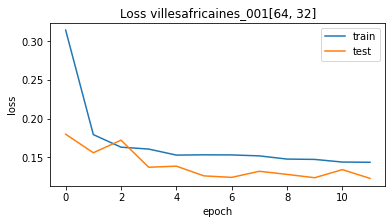

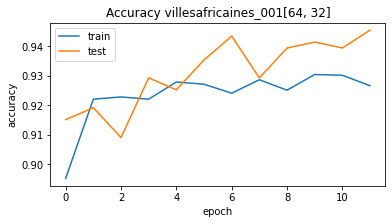

In [95]:
# training models
# fts

fts = features[course].copy()
target = labels[course].copy()
y=target
    
fts = fts.reshape(fts.shape[0], -1)
train_size = 0.8
x_train, x_rem, y_train, y_rem = train_test_split(fts, target, train_size=train_size, random_state=25)
x_test, x_val, y_test, y_val = train_test_split(x_rem, y_rem, train_size=0.5, random_state=25)
# print(year+':')
print(x_train.shape,x_test.shape,x_val.shape)
print(y_train.shape,y_test.shape,y_val.shape)


num_weeks = params[course]['num_weeks']
num_features = params[course]['num_features']
num_epochs = params[course]['num_epochs']

hidden_feature_num = [64,32]

current_timestamp = str(time.time())[:-2]
model=bidirectional_lstm
print(model.__name__)
history, scores, lstm = model(x_train, y_train, x_test, y_test, x_val, y_val,
                      week_type, feature_types, course, n_weeks=num_weeks,
                        hidden_feature_num=hidden_feature_num,
                      n_features=num_features, num_epochs=num_epochs)
print("{:<15} {:<8} ".format('metric','value'))
for ke, v in scores.items():
    if isinstance(v, float):
        v=round(v, 4)
    if ke!="feature_type":
        print("{:<15} {:<8} ".format(ke, v))
run_name = model.__name__ + "_" + course + "_" + current_timestamp
filename = str(course) + str(hidden_feature_num)
fig = plot_history(history=history, filename=filename)


In [65]:
S2 = ['I would attempt more problems.', 'I would improve my regularity of learning on the platform (have a daily or weekly schedule).', 'I would attempt more problems.', 'I would attempt more problems.', 'I would practice more for the quiz so I could solve it in fewer attempts.', 'I would improve my regularity of learning on the platform (have a daily or weekly schedule).', 'I would try to watch videos for the next weeks earlier.', 'I would attempt more problems.', 'I would improve my regularity of learning on the platform (have a daily or weekly schedule).', 'I would improve my regularity of learning on the platform (have a daily or weekly schedule).', 'I would attempt more problems.', 'I would attempt more problems.', 'I would attempt more problems.', 'I would improve my regularity of learning on the platform (have a daily or weekly schedule).', 'I would attempt more problems.', 'I would practice more for the quiz so I could solve it in fewer attempts.', 'I would improve my regularity of learning on the platform (have a daily or weekly schedule).', 'I would attempt more problems.', 'I would improve my regularity of learning on the platform (have a daily or weekly schedule).', 'I would attempt more problems.', 'I would practice more for the quiz so I could solve it in fewer attempts.', 'I would attempt more problems.', 'I would try to attempt quizzes for the next weeks earlier.', 'I would attempt more problems.', 'I would practice more for the quiz so I could solve it in fewer attempts.', 'I would attempt more problems.', 'I would attempt more problems.', 'I would improve my regularity of learning on the platform (have a daily or weekly schedule).', 'I would engage more heavily with videos (pausing, replaying, rewinding)', 'I would improve my regularity of learning on the platform (have a daily or weekly schedule).', 'I would attempt more problems.', 'I would improve my regularity of learning on the platform (have a daily or weekly schedule).', 'I would improve my regularity of learning on the platform (have a daily or weekly schedule).', 'I would attempt more problems.', 'I would attempt more problems.', 'I would improve my regularity of learning on the platform (have a daily or weekly schedule).', 'I would improve my regularity of learning on the platform (have a daily or weekly schedule).', 'I would attempt more problems.', 'I would attempt more problems.', 'I would practice more for the quiz so I could solve it in fewer attempts.', 'I would attempt more problems.', 'I would try to attempt quizzes for the next weeks earlier.', 'I would attempt more problems.', 'I would practice more for the quiz so I could solve it in fewer attempts.', 'I would attempt more problems.', 'I would attempt more problems.', 'I would improve my regularity of learning on the platform (have a daily or weekly schedule).', 'I would engage more heavily with videos (pausing, replaying, rewinding)', 'I would improve my regularity of learning on the platform (have a daily or weekly schedule).', 'I would attempt more problems.', 'I would improve my regularity of learning on the platform (have a daily or weekly schedule).', 'I would improve my regularity of learning on the platform (have a daily or weekly schedule).', 'I would attempt more problems.', 'I would attempt more problems.', 'I would improve my regularity of learning on the platform (have a daily or weekly schedule).', 'I would improve my regularity of learning on the platform (have a daily or weekly schedule).', 'I would attempt more problems.', 'I would attempt more problems.', 'I would improve my regularity of learning on the platform (have a daily or weekly schedule).', 'I would improve my regularity of learning on the platform (have a daily or weekly schedule).', 'I would attempt more problems.', 'I would improve my regularity of learning on the platform (have a daily or weekly schedule).', 'I would improve my regularity of learning on the platform (have a daily or weekly schedule).', 'I would watch video lectures immediately when they are released', 'I would attempt more problems.', 'I would try to watch videos for the next weeks earlier.', 'I would engage more heavily with videos (pausing, replaying, rewinding)', 'I would try to solve the quizzes faster.', 'I would engage more heavily with videos (pausing, replaying, rewinding)', 'I would try to solve the quizzes faster.', 'I would improve my regularity of learning on the platform (have a daily or weekly schedule).', 'I would attempt more problems.', 'I would improve my regularity of learning on the platform (have a daily or weekly schedule).', 'I would try to attempt quizzes for the next weeks earlier.', 'I would improve my regularity of learning on the platform (have a daily or weekly schedule).', 'I would try to watch videos for the next weeks earlier.', 'I would attempt more problems.', 'I would attempt more problems.', 'I would attempt more problems.', 'I would engage more heavily with videos (pausing, replaying, rewinding)', 'I would attempt more problems.']

In [66]:
pd.DataFrame(S2).value_counts()

I would attempt more problems.                                                                  35
I would improve my regularity of learning on the platform (have a daily or weekly schedule).    26
I would practice more for the quiz so I could solve it in fewer attempts.                        6
I would engage more heavily with videos (pausing, replaying, rewinding)                          5
I would try to attempt quizzes for the next weeks earlier.                                       3
I would try to watch videos for the next weeks earlier.                                          3
I would try to solve the quizzes faster.                                                         2
I would watch video lectures immediately when they are released                                  1
dtype: int64

In [96]:
student = fts[2608]
x_test[0] = student

In [97]:
problems = [13,14]
regularity = [0, 1, 9, 10, 11]

interventions = [problems, regularity]
student_count = 1
for inter in interventions:
    print(inter)
    updated_vals = []
    index  = 160 + np.array(inter)
    for i in inter:
        student[i] += 0.5
        if student[i] > 1:
            student[i] = 1
    x_test[student_count] = student
    student_count += 1
    student = fts[2608]

[13, 14]
[0, 1, 9, 10, 11]


In [70]:
student = fts[2608]
x_test[3] = student
problems = [13,14]
regularity = [0, 1, 9, 10, 11]

interventions = [problems, regularity]
student_count = 1
for inter in interventions:
    print(inter)
    updated_vals = []
    index  = 160 + np.array(inter)
    for i in inter:
        student[i] = 1
    x_test[student_count] = student
    student_count += 1
    student = fts[2608]

# S2_Actionability
# I would attempt more problems.                                                                  34
# I would improve my regularity of learning on the platform (have a daily or weekly schedule).    25
# I would practice more for the quiz so I could solve it in fewer attempts.                        6
# I would engage more heavily with videos (pausing, replaying, rewinding)                          5
# I would try to attempt quizzes for the next weeks earlier.                                       3
# I would try to watch videos for the next weeks earlier.                                          2
# I would try to solve the quizzes faster.                                                         2
# I would watch video lectures immediately when they are released                                  1
# Name: count, dtype: int64

[13, 14]
[0, 1, 9, 10, 11]


In [99]:
# preds = lstm.predict(x_test)
print('original prediction with what the student did in week 6', 1 - preds[0])
print('I would attempt more problems., 35 students suggested', 1 - preds[1])
print('I would improve my regularity of learning on the platform (have a daily or weekly schedule)., 26 students suggested', 1 - preds[2])


original prediction with what the student did in week 6 [0.34686083]
I would attempt more problems., 35 students suggested [0.48155123]
I would improve my regularity of learning on the platform (have a daily or weekly schedule)., 26 students suggested [0.5445063]


In [19]:
features = ['regularity_peak_dayhour', 'regularity_periodicity_m1',
         'delay_lecture','total_clicks', 'number_sessions', 'time_sessions_sum',
         'time_sessions_mean', 'time_between_sessions_std',
         'time_sessions_std', 'total_clicks_weekday',
         'total_clicks_weekend', 'ratio_clicks_weekend_day',
         'total_clicks_video', 'total_clicks_problem',
         'time_in__problem_sum', 'time_in__video_sum','total_clicks_Video.Load', 'weekly_prop_watched_mean',
         'weekly_prop_replayed_mean', 'weekly_prop_interrupted_mean',
         'total_clicks_Video', 'frequency_action_Video',
         'frequency_action_Video.Load', 'frequency_action_Video.Play',
         'frequency_action_Video.Pause', 'pause_duration_mean',
         'pause_duration_std', 'time_speeding_up_mean',
         'time_speeding_up_std','content_alignment', 'content_anticipation', 'student_speed']

In [35]:
lstm.predict(x_test)
print('original prediction with what the student did in week 6', 1 - preds[0])
print('I would attempt more problems., 35 students suggested', 1 - preds[1])
print('I would improve my regularity of learning on the platform (have a daily or weekly schedule)., 26 students suggested', 1 - preds[2])


16/16 [==============================] - 0s 2ms/step


In [30]:
print('original prediction with what the student did in week 6', 1 - preds[0])
print('I would attempt more problems., 35 students suggested', 1 - preds[1])
print('I would improve my regularity of learning on the platform (have a daily or weekly schedule)., 26 students suggested', 1 - preds[2])


original prediction with what the student did in week 6 [0.41868377]
I would attempt more problems., 35 students suggested [0.9120024]
I would improve my regularity of learning on the platform (have a daily or weekly schedule)., 26 students suggested [0.9449845]


In [21]:
original_pred = 0.6187301


In [22]:

# DSP	5192
# 	123
# VA	2608
# 	3170
# GEO	138
# 	291

In [23]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.13.0
